In [1]:
#Installing Nececcary Libraries With Messages Supressed
suppressPackageStartupMessages({
    library(tidyverse)
    library(repr)
    library(tidymodels)
})

options(repr.matrix.max.rows = 10)

#Set seed to make random results reproducible 
set.seed(13) 

#changing the default graph size:
options(repr.plot.width=10, repr.plot.height=8)

In [2]:
#Importing Heart Disease data from the UC Irvine Repository

url <- "https://archive.ics.uci.edu/static/public/45/heart+disease.zip"
temp <- tempfile()
download.file(url, temp)
data.hungary <- read.csv(unz(temp, "processed.hungarian.data"))
unlink(temp)

In [3]:
formatted_heart_disease<-data.hungary |> 
    #renaming columns 
    rename(age = X28, sex = X1, chest_pain_type = X2, resting_bp = X130, 
        cholesterol = X132, fasting_blood_sugar = X0, resting_ekg = X2.1, max_hr = X185, exercise_induced_angina = X0.1, 
        ST_drop_exercise = X0.2, ST_slope = X., fluoroscopy_count = X..1, thalassemia_type = X..2, vessel_narrow = X0.3
    )|>
    #transofrming variables from <char> to <int> or <fct>
    transform(resting_bp = as.integer(resting_bp), cholesterol = as.integer(cholesterol), 
        fasting_blood_sugar = as.factor(fasting_blood_sugar), resting_ekg = as.factor(resting_ekg), max_hr = as.integer(max_hr), 
        exercise_induced_angina = as.factor(exercise_induced_angina), ST_slope = as.factor(ST_slope),
        fluoroscopy_count = as.integer(fluoroscopy_count),thalassemia_type = as.factor(thalassemia_type), 
        vessel_narrow = as.factor(vessel_narrow), sex=as.factor(sex),chest_pain_type=as.factor(chest_pain_type))


Warning message in eval(substitute(list(...)), `_data`, parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(list(...)), `_data`, parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(list(...)), `_data`, parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(list(...)), `_data`, parent.frame()):
“NAs introduced by coercion”


In [4]:
#According to the db: 
    #sex (1 = male; 0 = female)

    #chest pain type:
            # -- Value 1: typical angina
            # -- Value 2: atypical angina
            # -- Value 3: non-anginal pain
            # -- Value 4: asymptomatic

    #exercise induced angina (1 = yes; 0 = no)

    #esting electrocardiographic results
            # -- Value 0: normal
            # -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
            # -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

    #(fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)

    #slope: the slope of the peak exercise ST segment
    #         -- Value 1: upsloping
    #         -- Value 2: flat
    #         -- Value 3: downsloping

    #thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

    #num: diagnosis of heart disease (angiographic disease status)
            # -- Value 0: < 50% diameter narrowing
            # -- Value 1: > 50% diameter narrowing
            # (in any major vessel: attributes 59 through 68 are vessels)

#Refactoring the above categorical variables to make the data more readable and easier to work with:
formatted_heart_disease<-formatted_heart_disease|>
    mutate(sex=fct_recode(sex, "male"="1", "female"="0"
    ))|>
    mutate(chest_pain_type=fct_recode(chest_pain_type,
        "typical_angina"="1",
        "atypical_angina"="2",
        "non_anginal_pain"="3",
        "asymptomatic"="4"
    ))|>
    mutate(exercise_induced_angina=fct_recode(exercise_induced_angina,
        "yes"="1",
        "no"="0"
    ))|>
    mutate(resting_ekg=fct_recode(resting_ekg,
        "normal"="0",
        "ST-T_wave_abnormality"="1",
        "left_ventricular_hypertrophy"="2"
    ))|>
    mutate(fasting_blood_sugar=fct_recode(fasting_blood_sugar,
        "above120mg/dl"="1",
        "below120mg/dl"="0"
    ))|>
    mutate(ST_slope=fct_recode(ST_slope,
        "upsloping"="1",
        "flat"="2",
        "downsloping"="3"
    ))|>
    mutate(thalassemia_type=fct_recode(thalassemia_type,
        "normal"="3",
        "fixed_defect"="6",
        "reversable_defect"="7")
    )|>
    mutate(vessel_narrow=fct_recode(vessel_narrow,
        "below_50%of_d"="0",
        "above_50%of_d"="1"))
        
formatted_heart_disease


age,sex,chest_pain_type,resting_bp,cholesterol,fasting_blood_sugar,resting_ekg,max_hr,exercise_induced_angina,ST_drop_exercise,ST_slope,fluoroscopy_count,thalassemia_type,vessel_narrow
<int>,<fct>,<fct>,<int>,<int>,<fct>,<fct>,<int>,<fct>,<dbl>,<fct>,<int>,<fct>,<fct>
29,male,atypical_angina,120,243,below120mg/dl,normal,160,no,0,?,NA,?,below_50%of_d
29,male,atypical_angina,140,NA,below120mg/dl,normal,170,no,0,?,NA,?,below_50%of_d
30,female,typical_angina,170,237,below120mg/dl,ST-T_wave_abnormality,170,no,0,?,NA,fixed_defect,below_50%of_d
31,female,atypical_angina,100,219,below120mg/dl,ST-T_wave_abnormality,150,no,0,?,NA,?,below_50%of_d
32,female,atypical_angina,105,198,below120mg/dl,normal,165,no,0,?,NA,?,below_50%of_d
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
52,male,asymptomatic,160,331,below120mg/dl,normal,94,yes,2.5,?,NA,?,above_50%of_d
54,female,non_anginal_pain,130,294,below120mg/dl,ST-T_wave_abnormality,100,yes,0.0,flat,NA,?,above_50%of_d
56,male,asymptomatic,155,342,above120mg/dl,normal,150,yes,3.0,flat,NA,?,above_50%of_d


In [5]:
#Before proceeding further into analyzing the data, we need to split it into a training and testing set. The testing set will not be analyzed and will be set aside for testing later.
# %75 of data will be used for testing and the remaining %25 for training
heart_disease_split<-initial_split(formatted_heart_disease, prop=0.75, strata=vessel_narrow)
heart_disease_train<-training(heart_disease_split)
heart_disease_test<-testing(heart_disease_split)


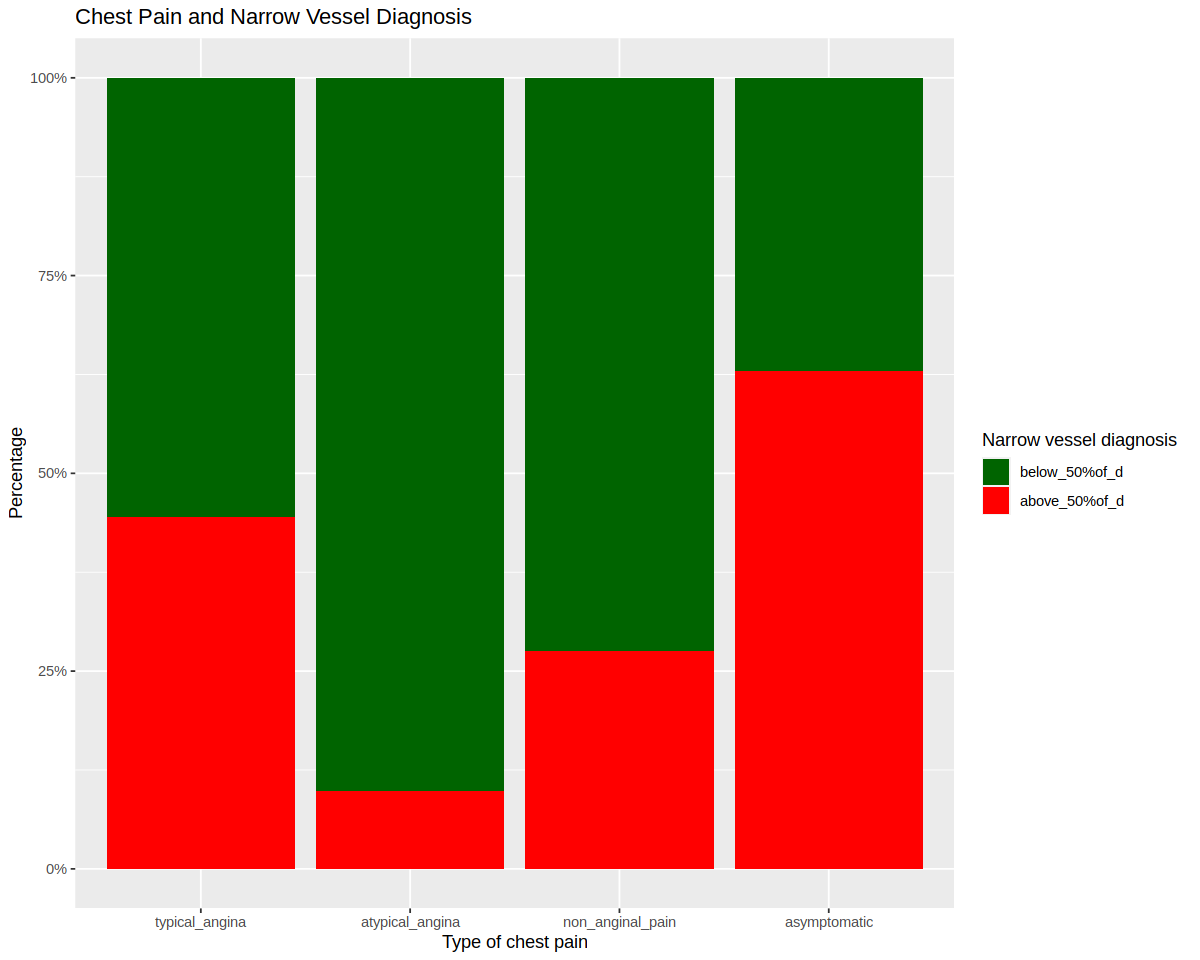

In [6]:
#Exploring The Relationship Between Chest Pain Type and narrow vessel diagnostic:
pain_vessel_graph<-heart_disease_train|>
    ggplot(aes(x=chest_pain_type, fill=vessel_narrow))+
        geom_bar(position="fill")+
        scale_y_continuous(labels = percent_format(scale = 100)) +
        ylab("Percentage")+
        labs( title = "Chest Pain and Narrow Vessel Diagnosis", x="Type of chest pain", fill="Narrow vessel diagnosis")+
        scale_fill_manual(values=c("darkgreen","red"))
        

pain_vessel_graph

From the bar plot above, we can see that most heart disease diagnoses are associated with typical angina pain or asymptomatic pain. It is also clear that chest pain type can be useful for predicting the heart disease diagnosis. 

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


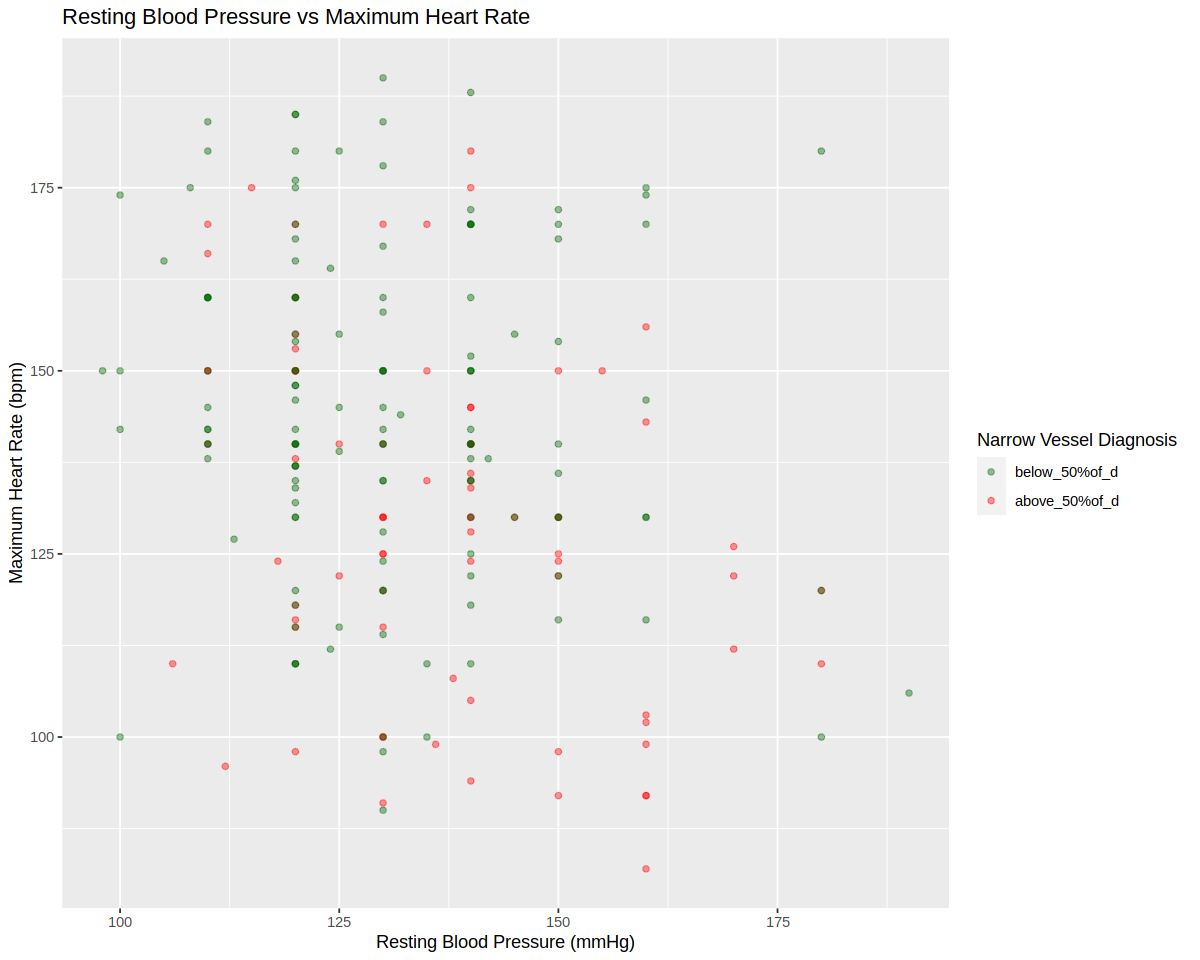

In [7]:
#Exploring the relationship between resting blood pressure, maximum heart rate and the narrow vesel diagnosis:
restingbp_maxhr_graph<-heart_disease_train|>
    ggplot(aes(x=resting_bp, y=max_hr, color=vessel_narrow))+
        geom_point(alpha=0.4)+
        labs(title="Resting Blood Pressure vs Maximum Heart Rate", x="Resting Blood Pressure (mmHg)", y="Maximum Heart Rate (bpm)", color="Narrow Vessel Diagnosis")+
        scale_color_manual(values=c("darkgreen","red"))

restingbp_maxhr_graph